## SHAP analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import shap
from rdkit import Chem
from rdkit.Chem import Draw

2024-08-05 19:28:41.974811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 19:28:42.135656: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 19:28:42.176588: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 19:28:42.820969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

##### Create the SHAP Explainer

In [2]:
# Set the visible GPU device to GPU 0
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

# Ensure GPU memory growth is set at the very beginning
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
data = pd.read_pickle('./Input/low_cv_dta_new_whole_feat.pkl')

# Prepare features and target. Convert to DataFrame
X_ecfp4 = np.array(data['ECFP4'].tolist())
X_seq = np.array(data['Sequence_Encode'].tolist())
X_ecif = np.array(data['ECIF'].tolist())
y = data['Value'].values

# Split data into training and testing sets
X_ecfp4_train, X_ecfp4_test, X_seq_train, X_seq_test, X_ecif_train, X_ecif_test, y_train, y_test, train_index, test_index = train_test_split(
    X_ecfp4, X_seq, X_ecif, y, data.index, test_size=0.2, random_state=42)

In [4]:
# Load the trained model
model = tf.keras.models.load_model('./Output/Final/low_cv_dta_ECFP4_Seq_ECIF_model.h5')

2024-08-05 19:29:27.925053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 19:29:28.054962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [5]:
# Sample a smaller subset for the SHAP analysis
sample_size = 10000  # Adjust this size based on your GPU memory constraints
combined_train_data_sampled = shap.sample(np.hstack([X_ecfp4_train, X_seq_train, X_ecif_train]), sample_size)

# Ensure combined_train_data_sampled is a NumPy array
combined_train_data_sampled = combined_train_data_sampled.astype(np.float32)


In [6]:
# Define a function to predict using the model
def model_predict(inputs):
    return model.predict([inputs[:, :X_ecfp4_train.shape[1]], 
                          inputs[:, X_ecfp4_train.shape[1]:X_ecfp4_train.shape[1] + X_seq_train.shape[1]], 
                          inputs[:, X_ecfp4_train.shape[1] + X_seq_train.shape[1]:]])


##### Explain the Test Data

In [7]:
# Create the SHAP explainer
explainer = shap.DeepExplainer(model, [X_ecfp4_train[:sample_size], X_seq_train[:sample_size], X_ecif_train[:sample_size]])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [8]:
# For the test data, use a subset as well
test_sample_size = 1000  # Adjust this size based on your GPU memory constraints
combined_test_data_sampled = shap.sample(np.hstack([X_ecfp4_test, X_seq_test, X_ecif_test]), test_sample_size)

In [9]:
# Ensure combined_test_data_sampled is a NumPy array
combined_test_data_sampled = combined_test_data_sampled.astype(np.float32)

In [10]:
# Compute SHAP values for the test set
shap_values = explainer.shap_values([X_ecfp4_test[:test_sample_size], X_seq_test[:test_sample_size], X_ecif_test[:test_sample_size]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


##### Visualize the SHAP Values

In [11]:
import matplotlib.pyplot as plt

In [13]:
# Ensure that the SHAP values are correctly calculated
shap_values_ecfp4 = shap_values[0][0]
shap_values_seq = shap_values[0][1]
shap_values_ecif = shap_values[0][2]

In [14]:
# Stack the SHAP values for all features
shap_values_concat = np.hstack([shap_values_ecfp4, shap_values_seq, shap_values_ecif])


In [15]:
# Stack the corresponding test data
X_test_concat = np.hstack([X_ecfp4_test[:test_sample_size], X_seq_test[:test_sample_size], X_ecif_test[:test_sample_size]])

In [16]:
# Feature names
feature_names = (["ECFP4_Bit" + str(i) for i in range(X_ecfp4_test.shape[1])] + 
                 ["Sequence_" + str(i) for i in range(X_seq_test.shape[1])] +
                 ["ECIF_" + str(i) for i in range(X_ecif_test.shape[1])])

In [17]:
# Sum absolute SHAP values to find the most important features
importance = np.sum(np.abs(shap_values_concat), axis=0)
top_indices = np.argsort(importance)[-20:]  # Get indices of top 20 features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


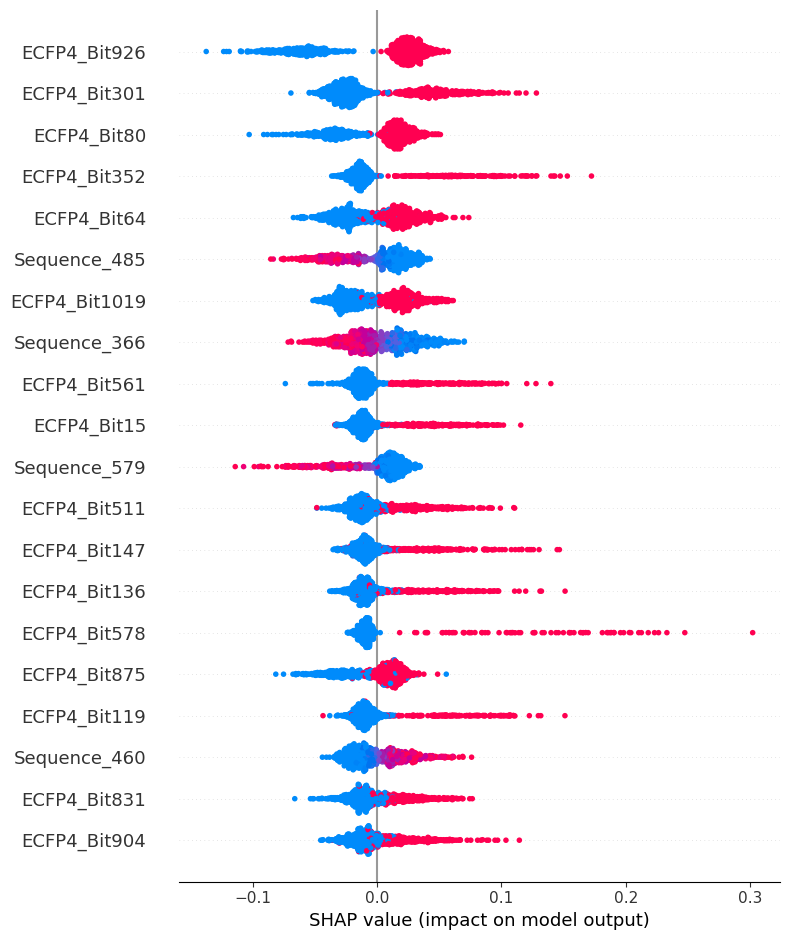

In [18]:
# Create a summary plot for the top features
shap.summary_plot(shap_values_concat[:, top_indices], X_test_concat[:, top_indices], feature_names=np.array(feature_names)[top_indices], show=False, color_bar=False)
plt.show()